In [11]:
import torch
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from models import Autoencoder

In [12]:
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 14
latent_dim = 3
bounds = (0.0*np.ones(latent_dim), 1.0*np.ones(latent_dim))
x_bounds = [
    (1e-16, 1),  # 0
    (1e-16, 1),  # 1
    (1e-16, 1),  # 2
    (5, 300),  # 3
    (0.3, 1),  # 4
    (1e-3, 50e-3),  # 5
    (-7, -1),  # 6
    (-7, -1),  # 7
    (1e-16, 1),  # 8
    (1e-16, 1),  # 9
    (1e-16, 1),  # 10
    (1e-16, 1),  # 11
    (1e-16, 1),  # 12
    (1e-16, 1),  # 13
]

model_path = f"../out/mpc/model_{input_dim}d_{latent_dim}l_500iter_exp_decay_alpha_05.pt"
autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim, out_bounds=x_bounds)

try:
    checkpoint = torch.load(model_path, weights_only=True)
    state_dict = {k.replace('module.', ''): v for k, v in checkpoint['model'].items()}
    autoencoder.load_state_dict(state_dict)
except:
    "Could not load pretrained model"
    try:
        state_dict = torch.load(model_path, weights_only=True)
        autoencoder.load_state_dict(state_dict)
    except:
        "Could not load pretrained model"
autoencoder.to(device)

autoencoder.eval()
encoder = autoencoder.encoder
decoder = autoencoder.decoder

In [7]:
# Nominal values
x_init = [ 7.53774966e-02,  1.00000000e+00,  9.95072347e-01,  1.55629154e+02,
                       7.03081769e-01,  3.42407916e-02, -7.00000000e+00, -1.00000000e+00,
                       1.00000000e+00,  5.55111512e-17,  3.27102398e-01,  3.85344826e-01,
                       6.26874649e-01,  1.00000000e+00]
with torch.no_grad():
    z_init = encoder(torch.tensor(x_init, dtype=torch.float32, device=device)).cpu().numpy()
    x_init_reconstruct = decoder(torch.tensor(z_init, dtype=torch.float32, device=device)).cpu().numpy()

In [8]:
np.sqrt(np.mean((x_init - x_init_reconstruct)**2))

4.844635668130503

In [10]:
x_init

[0.0753774966,
 1.0,
 0.995072347,
 155.629154,
 0.703081769,
 0.0342407916,
 -7.0,
 -1.0,
 1.0,
 5.55111512e-17,
 0.327102398,
 0.385344826,
 0.626874649,
 1.0]

In [9]:
x_init_reconstruct

array([ 5.4488438e-01,  5.3795731e-01,  4.9873915e-01,  1.3802881e+02,
        6.4120018e-01,  2.3446744e-02, -3.8648431e+00, -3.7274809e+00,
        4.8644632e-01,  5.1133102e-01,  5.1611090e-01,  5.0454056e-01,
        5.0811338e-01,  4.7754228e-01], dtype=float32)

In [59]:
X = [] # will be of shape (B, n_expl, n_dim)
J = [] # will be of shape (B, n_expl, 1)
Xopt = []
Jopt = []

for i in range(1000,1200):
    experiment = i
    with open(f'../../efficient-calibration-embedded-MPC/results/params/{experiment:04}.pkl', 'rb') as f:
        params = pickle.load(f)
    with open(f'../../efficient-calibration-embedded-MPC/results/experiment_{experiment:04}_res_slower1_500iter_GLIS_PC.pkl', 'rb') as f:
        experiment = pickle.load(f)
    X.append(experiment['X_sample'])
    J.append(experiment['J_sample'])
    Xopt.append(experiment['x_opt'])
    Jopt.append(experiment['J_opt'])
    
X_sample = np.stack(X, axis=1)
J_sample = np.stack(J, axis=1)
X_best = np.stack(Xopt, axis=0)
J_best = np.stack(Jopt, axis=0)

In [60]:
dict_x0 = {
    'Q_{\Delta u}': 0.1,
    'q_{y_{11}}': 0.1,
    'q_{y_{22}}': 0.9,
    'N_{p}': 40,
    '\epsilon_{c}': 1.0,
    'T_{s}^{MPC}': 25e-3,
    r'\log{\text{QP}_{{\epsilon}_{abs}}}': -3,
    r'\log{\text{QP}_{{\epsilon}_{rel}}}': -2,
    'W_{w_{11}}': 0.1,
    'W_{w_{22}}': 0.4,
    'W_{w_{33}}': 0.1,
    'W_{w_{44}}': 0.4,
    'W_{v_{11}}': 0.5,
    'W_{v_{22}}': 0.5
}

var_names = list(dict_x0.keys())

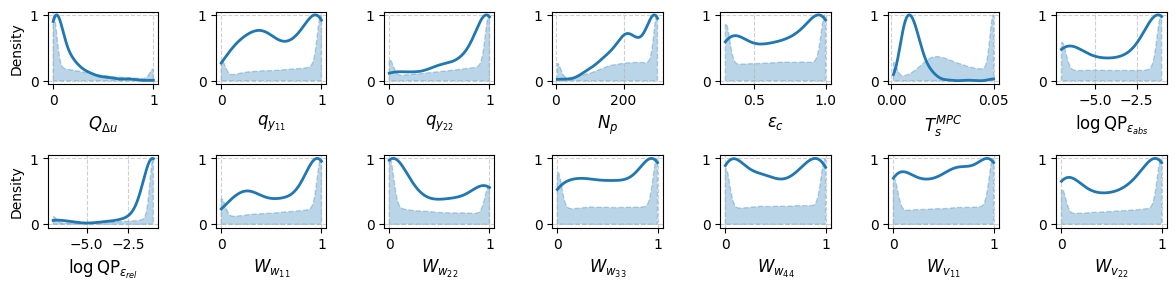

In [61]:
import matplotlib.ticker as ticker
import numpy as np
from scipy.stats import gaussian_kde

# Colormap for consistent colors
cmap = plt.get_cmap("tab10")

# Create subplots: 2 rows, 7 columns
fig, axes = plt.subplots(2, 7, figsize=(12, 3))
axes = axes.flatten()

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Use scientific notation outside [10^-2, 10^2]
formatter.set_useOffset(False)

# Plot KDEs
for idx, ax in enumerate(axes[:X_sample.shape[-1]]):
    # Compute the KDE
    data = X_sample[:, :, idx].flatten()
    kde = gaussian_kde(data, bw_method='silverman')  # You can adjust bandwidth here
    x_vals = np.linspace(np.min(data), np.max(data), 1000)  # Generate points for x-axis
    y_vals = kde(x_vals)  # Evaluate KDE at the points
    y_vals /= np.max(y_vals)  # Normalize to [0, 1]
    # ax.plot(x_vals, y_vals, color='tab:blue', alpha=0.7, lw=2)
    ax.fill_between(x_vals, y_vals, color='tab:blue', alpha=0.3, linestyle='--')
    
    # Compute the KDE
    data = X_best[:, idx].flatten()
    kde = gaussian_kde(data, bw_method='silverman')  # You can adjust bandwidth here
    # x_vals = np.linspace(np.min(data), np.max(data), 1000)  # Generate points for x-axis
    y_vals = kde(x_vals)  # Evaluate KDE at the points
    y_vals /= np.max(y_vals)  # Normalize to [0, 1]
    # Plot the KDE
    ax.plot(x_vals, y_vals, color='tab:blue', alpha=1, lw=2)
    # ax.fill_between(x_vals, y_vals, color='tab:blue', alpha=0.3)
    
    ax.set_xlabel(f"${var_names[idx]}$", fontsize=12)

    # Set y-label only for the leftmost column (idx % 7 == 0)
    if idx % 7 == 0:
        ax.set_ylabel("Density", fontsize=10)
                      
    # ax.yaxis.set_major_formatter(formatter)
    # ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Format with 2 decimal places
    ax.grid(True, linestyle='--', alpha=0.6)

# Turn off unused axes
for ax in axes[X_sample.shape[-1]:]:
    ax.axis('off')

fig.align_ylabels(axes)

# Adjust layout and add a title
fig.subplots_adjust(wspace=0.5, hspace=0.7)  # Reduce horizontal and vertical space
# plt.suptitle("Variable Distributions (KDE)", fontsize=16, y=1.05)
plt.tight_layout()

# plt.savefig('fig/mpc/mpc_distribution_comparison.pdf')

plt.show()

In [62]:
import os
def reconstruct_best_cost(J_sample):
    J_best = [J_sample[0]]  # Initialize with the first cost
    for J in J_sample[1:]:  # Iterate through the rest of the costs
        J_best.append(min(J, J_best[-1]))  # Update with the minimum so far
    return J_best

algo = 'GLIS' # GLIS or BO
machine = 'PC' # PC or PI
eps_calc = 1.0
iter_max_plot = 50

plt.close('all')

X_sample = []
J_sample = []
X_best = []
J_best = []

for experiment in range(1000, 1200):
    with open(f'../../efficient-calibration-embedded-MPC/results/experiment_{experiment:04}_res_slower1_500iter_GLIS_PC.pkl', 'rb') as f:
        results = pickle.load(f)    

    # Example usage
    X_sample.append(results['X_sample'])
    X_best.append(results['x_opt'])
    J = results['J_sample']  # Your sequence of costs
    J_sample.append(J)
    J_best.append(reconstruct_best_cost(J))

X_sample = np.stack(X_sample, axis=0)
X_best = np.stack(X_best, axis=0)
J_sample = np.stack(J_sample, axis=0)
J_best = np.stack(J_best, axis=0)

In [63]:
J_best.max(axis=0).shape

(500, 1)

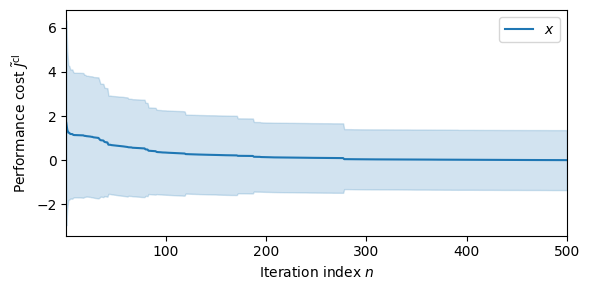

In [64]:
max_evals = J_best.shape[1]
J_best_mean = np.mean(J_best[:,:,0], axis=0)
J_best_std = np.std(J_best[:,:,0], axis=0)
# Plot the result
fig = plt.figure(figsize=(6, 3))

plt.plot(np.arange(max_evals)+1, J_best_mean, label="$x$", color='tab:blue')
plt.fill_between(
    np.arange(max_evals)+1,
    J_best_mean - J_best_std,
    J_best_mean + J_best_std,
    color='tab:blue',
    alpha=0.2,
    label=''
)

# plt.yscale('log')  # Log scale for y-axis
plt.xlim(1, max_evals)
plt.xlabel("Iteration index $n$")
plt.ylabel(r"Performance cost $\tilde{J}^{\mathrm{cl}}$")

plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

In [65]:
X_best.shape

(200, 14)

In [66]:
dim_pairs

[(9, 6),
 (12, 6),
 (9, 2),
 (1, 8),
 (5, 8),
 (13, 5),
 (8, 9),
 (9, 4),
 (1, 11),
 (3, 1)]

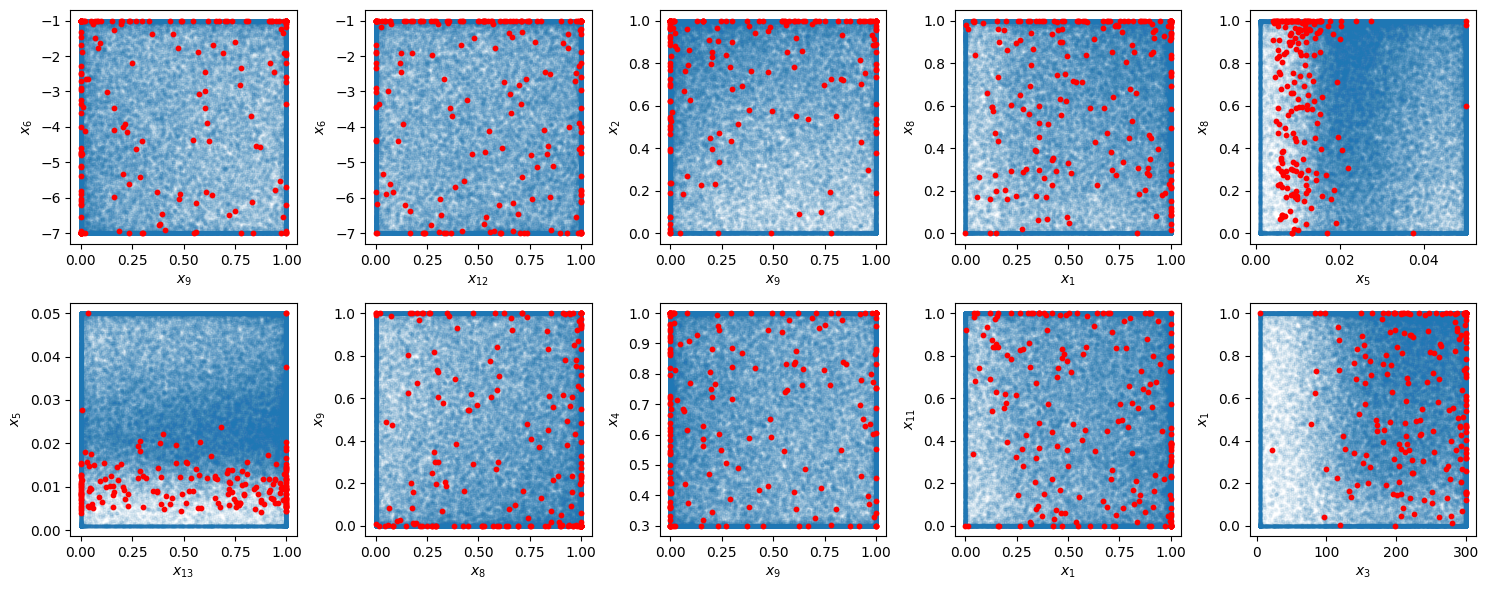

In [68]:
# Randomly select 10 unique pairs of dimensions
dim_pairs = [tuple(np.random.choice(X_sample.shape[-1], size=2, replace=False)) for _ in range(10)]
dim_pairs = [(9, 6),
             (12, 6),
             (9, 2),
             (1, 8),
             (5, 8),
             (13, 5),
             (8, 9),
             (9, 4),
             (1, 11),
             (3, 1)]

# Define subplot grid (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()  # Flatten for easier iteration

# Loop through each selected pair and plot
for ax, (first_idx, second_idx) in zip(axes, dim_pairs):
    ax.scatter(
        X_sample[:, :, first_idx], X_sample[:, :, second_idx], 
        s=5, alpha=0.05, color='tab:blue'
    )
    ax.scatter(
        X_best[:, first_idx], X_best[:, second_idx],
        s=10, alpha=1, color='red'
    )
    ax.set_xlabel(f'$x_{{{first_idx}}}$')
    ax.set_ylabel(f'$x_{{{second_idx}}}$')
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_aspect('equal')

# Adjust layout
plt.tight_layout()
plt.show()

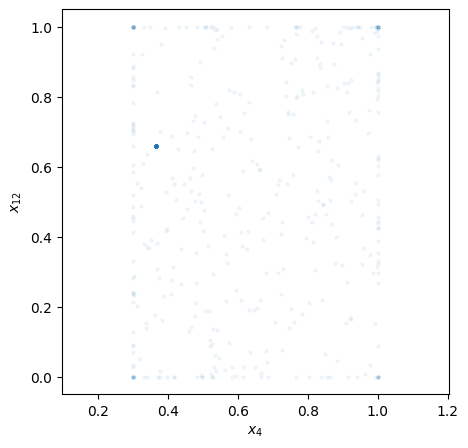

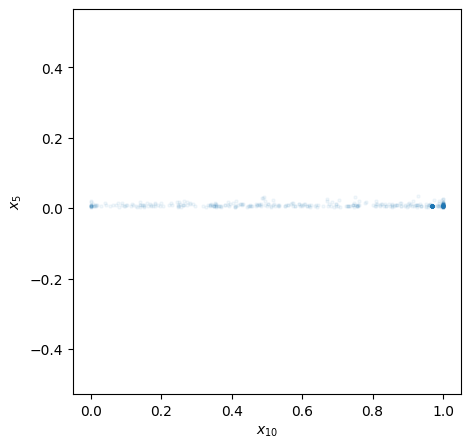

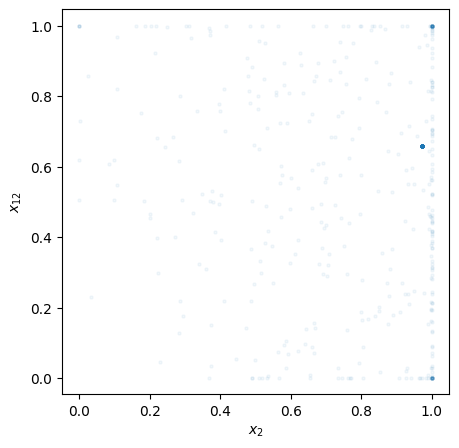

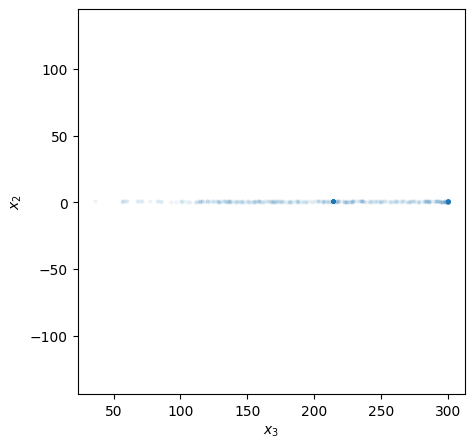

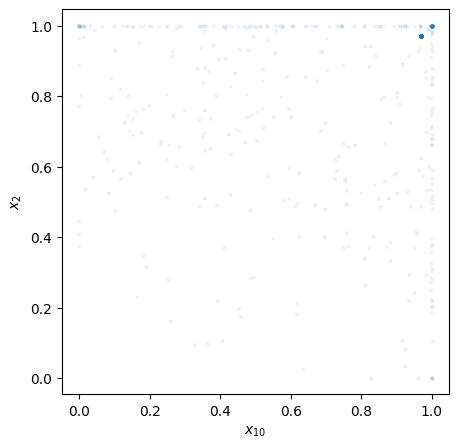

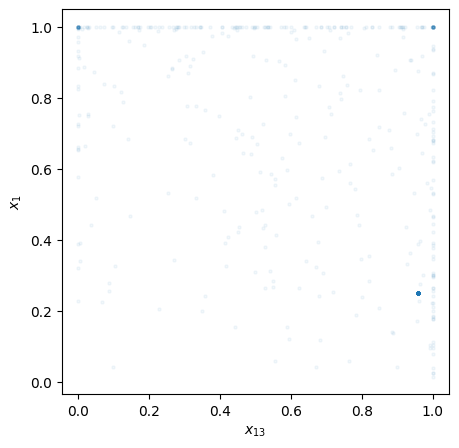

In [38]:
for i in range(6):
    first_idx, second_idx = np.random.choice(Xopt.shape[-1], size=2, replace=False)

    plt.figure(figsize=(5, 5))
    plt.scatter(Xopt[:, first_idx], Xopt[:, second_idx], label='_nolegend_', s=5, alpha=0.05, color='tab:blue')
    plt.xlabel(f'$x_{{{first_idx}}}$')
    plt.ylabel(f'$x_{{{second_idx}}}$')
    plt.axis('equal')
    plt.show()

In [13]:
experiment.keys()

dict_keys(['X_sample', 'J_sample', 'idx_opt', 'x_opt', 'J_opt', 'eps_calc', 'time_iter', 'time_f_eval', 'time_opt_acquisition', 'time_fit_surrogate', 'out', 'method'])